In [1]:
from moldy.case_studies.grub_sim.nempc_grub_sim import nempc_grub_setup
from moldy.case_studies.grub_sim.model_grub_sim import GrubSim
from moldy.validation.control.control_test import ControlTest

tester = ControlTest(ground_truth=GrubSim(), 
                    nempc_setup=nempc_grub_setup,
                    sim_seconds=20.0,
                    num_step_commands=5,
                    states_of_interest=[6, 7],
                    )

GrubSim: mass: 5.0, stiffness: 14.07, damping: 2.73, alpha: 2.856, h: 0.23, r: 0.095


In [2]:
import numpy as np

horizon = 30
numSims = 1000
numParents = 300
numStrangers = 100
numKnotPoints = 1
selection_method = "tournament"
tournament_size = 5
crossover_method = "knot_point"
mutation_probability = 0.1
Q = np.diag([0,0,0,0, 0.1, 0.1, 50, 50, ])  
R = 1e-2 * np.diag([1.0, 1.0, 1.0, 1.0])
ctrl_dt = 0.02
nempc_params = {"horizon": horizon,
                "numSims": numSims,
                "numParents": numParents,
                "numStrangers": numStrangers,
                "numKnotPoints": numKnotPoints,
                "selection_method": selection_method,
                "tournament_size": tournament_size,
                "crossover_method": crossover_method,
                "mutation_probability": mutation_probability,
                "Q": Q,
                "R": R,
                }
def setup_wrapper(trial_dir=None, x0=None):
    return nempc_grub_setup(trial_dir=trial_dir, x0=x0, horizon=horizon, numSims=numSims, numParents=numParents, numStrangers=numStrangers, numKnotPoints=numKnotPoints, Q=Q, R=R, ctrl_dt=ctrl_dt)

tester.run_trials("/home/daniel/catkin_ws/src/moldy/case_studies/grub_sim/results/test_results/",
                "/home/daniel/catkin_ws/src/moldy/case_studies/grub_hw/results/best_models/",
                run_analytical=False,
                nempc_setup=setup_wrapper,
                nempc_params=nempc_params,
                ctrl_dt=ctrl_dt,
                test_name="hw_best_models",
                )

In [1]:
from moldy.validation.prediction.prediction_validation import PredictionValidation

from moldy.case_studies.grub_sim.model_grub_sim import GrubSim
from moldy.case_studies.grub_sim.learnedModel_grub_sim import LearnedModel_GrubSim

data_path = "/home/daniel/catkin_ws/src/moldy/case_studies/grub_sim/data/validation_inputdata.npy"

pred_tester = PredictionValidation(LearnedModel_GrubSim, 3000, GrubSim(old_params=False), data_path, data_start_location=50000)
pred_tester.run_trials(
    "/home/daniel/catkin_ws/src/moldy/case_studies/grub_sim/results/best_models/",
                                  "/home/daniel/catkin_ws/src/moldy/case_studies/grub_sim/results/test_results/",
                                  "data_test"
                                  )

GrubSim: mass: 5.0, stiffness: 14.07, damping: 2.73, alpha: 2.856, h: 0.23, r: 0.095


In [2]:
pred_tester.results.keys()

dict_keys(['/home/daniel/catkin_ws/src/moldy/case_studies/grub_sim/results/best_models/grub_2048net_150000', 'ground_truth'])

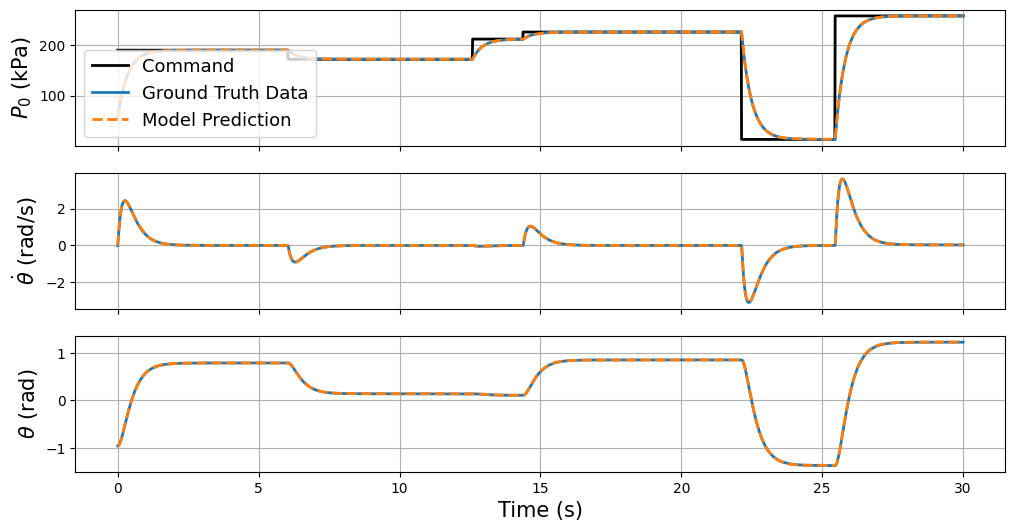

In [4]:
from moldy.figure_generation.fig_utils import plot_prediction_performance
import matplotlib.pyplot as plt
import numpy as np

state_labels = ["$P_0$ (kPa)", "$P_1$ (kPa)", "$P_2$ (kPa)", "$P_3$ (kPa)", "$\\dot{\\theta}$ (rad/s)", "$\\dot{\\phi}$ (rad/s)", \
                "$\\theta$ (rad)", "$\\phi$ (rad)"]
states_of_interest = [0, 4, 6]
ground_truth_data = pred_tester.results["ground_truth"]
pred_tester.results.pop("ground_truth")

plt.rc('pdf',fonttype = 42)

fig, axs = plt.subplots(len(states_of_interest), 1, figsize=(12, len(states_of_interest)*2), sharex=True)

plt.rc('axes', labelsize=15)

timestep = np.linspace(0, pred_tester.results[list(pred_tester.results.keys())[0]]["learned_predictions"].shape[0]//100, pred_tester.results[list(pred_tester.results.keys())[0]]["learned_predictions"].shape[0])

for i in range(len(states_of_interest)):
    if i < 1:
        axs[i].plot(timestep, ground_truth_data[:, i+8], "-k", label="Command", linewidth=2.0)
    axs[i].plot(timestep, ground_truth_data[:, states_of_interest[i]], c="C0", label="Ground Truth Data", linewidth=2.0)
    axs[i].plot(timestep, pred_tester.results[list(pred_tester.results.keys())[0]]["learned_predictions"][:, states_of_interest[i]], "--", c="tab:orange", label="Model Prediction", linewidth=2.0)
    axs[i].grid()
    axs[i].set_ylabel(state_labels[states_of_interest[i]])

axs[-1].set_xlabel("Time (s)")
axs[0].legend(loc="lower left", fontsize=13)

pred_tester.results["ground_truth"] = ground_truth_data

plt.savefig("/home/daniel/catkin_ws/src/moldy/figure_generation/generated_figures/grub_prediction_sim.pdf", bbox_inches="tight")
